In [1]:

import torch
import torch.nn as nn
import numpy as np


try:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.7.1+cu126
CUDA available: True


In [2]:
!pip install tiktoken


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import importlib
import tiktoken

importlib.metadata.version("tiktoken")

'0.9.0'

In [4]:
tokenizer = tiktoken.get_encoding("gpt2")

In [5]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias = False):
    super().__init__()
    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads

    self.W_query = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer(
        "mask",
        torch.triu(torch.ones(context_length, context_length), diagonal =1)
    )


  def forward(self, x):
    batch, num_tokens, d_in = x.shape
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)


    keys = keys.view(batch, num_tokens, self.num_heads, self.head_dim)
    values = values.view(batch, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(batch, num_tokens, self.num_heads, self.head_dim)

    keys = keys.transpose(1,2)
    values = values.transpose(1,2)
    queries = queries.transpose(1,2)

    attn_scores = queries @ keys.transpose(2,3)

    mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

    attn_scores = attn_scores.masked_fill(mask_bool, -torch.inf) 

    attn_weights = torch.softmax(attn_scores/ keys.shape[-1]**0.5 , dim=-1)
    attn_weights = self.dropout(attn_weights)

    context_vecs = (attn_weights @ values).transpose(1,2)  

    context_vecs = context_vecs.contiguous().view(batch, num_tokens, self.d_out)
    context_vec = self.out_proj(context_vecs)

    return context_vec

In [6]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 512,
    "emb_dim": 384,
    "num_heads": 6,
    "n_layers": 6,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [7]:
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased = False)
    norm_x = (x - mean) / torch.sqrt(var + self.eps)       
    return self.scale * norm_x + self.shift

class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0/torch.pi)) *
        (x + 0.044715 * torch.pow(x, 3))
    ))

class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
        GELU(),
        nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
    )

  def forward(self, x):
    return self.layers(x)

In [8]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.attn = MultiHeadAttention(
        d_in = cfg["emb_dim"],
        d_out = cfg["emb_dim"],
        context_length = cfg["context_length"],
        num_heads = cfg["num_heads"],
        dropout = cfg["drop_rate"],
        qkv_bias = cfg["qkv_bias"]
    )
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):
    
     short_cut = x
     x = self.norm1(x)
     x = self.attn(x)
     x = self.drop_shortcut(x)
     x = x + short_cut  

     
     short_cut = x  
     x = self.norm2(x)
     x = self.ff(x)
     x = self.drop_shortcut(x)
     x = x + short_cut 

     return x

In [9]:
class GPTModel(nn.Module):

  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])
    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
    )
    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
        cfg["emb_dim"], cfg["vocab_size"], bias = False
    )

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)

    return logits


In [10]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    """Simple text generation function"""
    model.eval()
    for _ in range(max_new_tokens):

        idx_cond = idx[:, -context_size:]
        
   
        with torch.no_grad():
            logits = model(idx_cond)
        
       
        logits = logits[:, -1, :] 
        
    
        probs = torch.softmax(logits, dim=-1) 
        
        
        idx_next = torch.argmax(probs, dim=-1, keepdim=True)  
        
   
        idx = torch.cat((idx, idx_next), dim=1)  
    
    return idx

In [11]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) 
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")


In [12]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
  def __init__(self, txt, tokenizer, max_length, stride):
    self.input_ids = []
    self.target_ids = []

    token_ids = tokenizer.encode(txt, allowed_special = {"<|endoftext|>"})

    for i in range(0, len(token_ids)- max_length, stride):
      input_chunk = token_ids[i:i + max_length]
      target_chunk = token_ids[i+1: i + max_length + 1]

      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length = 256,
                         stride = 256, shuffle= True, drop_last = True,
                         num_workers = 0, pin_memory=None, prefetch_factor=4, persistent_workers=None):

  tokenizer = tiktoken.get_encoding("gpt2")

  dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)


  if pin_memory is None:
    pin_memory = torch.cuda.is_available()
  if persistent_workers is None:
    persistent_workers = num_workers > 0

  dl_kwargs = {
      "dataset": dataset,
      "batch_size": batch_size,
      "shuffle": shuffle,
      "drop_last": drop_last,
      "num_workers": num_workers,
      "pin_memory": pin_memory,
      "persistent_workers": persistent_workers,
  }
  if num_workers and num_workers > 0:
      dl_kwargs["prefetch_factor"] = prefetch_factor

  dataloader = DataLoader(**dl_kwargs)
  return dataloader

In [13]:
class GPTModel(nn.Module):

  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])
    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
    )
    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
        cfg["emb_dim"], cfg["vocab_size"], bias = False
    )

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)

    return logits

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

In [14]:
def calc_loss_batch(input_batch, target_batch, model, device):
  input_batch, target_batch = input_batch.to(device), target_batch.to(device)
  logits = model(input_batch)
  loss = nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())
  return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
  total_loss = 0.
  if len(data_loader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))

  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      total_loss += loss.item()
    else:
      break
  return total_loss / num_batches

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else"cpu")
device

device(type='cuda')

In [16]:
from datasets import load_dataset

ds = load_dataset("roneneldan/TinyStories")

In [17]:
train_text_data_str = " <|endoftext|> ".join(ds['train']['text'])
total_tokens = len(tokenizer.encode(train_text_data_str, allowed_special={'<|endoftext|>'}))

print(f"Total tokens: {total_tokens:,}")
print(f"Number of stories: {len(ds['train']['text']):,}")
print(f"Average tokens per story: {total_tokens / len(ds['train']['text']):.1f}")

Total tokens: 475,890,377
Number of stories: 2,119,719
Average tokens per story: 224.5


In [18]:
val_text_data_str = " <|endoftext|> ".join(ds['validation']['text'])
total_tokens = len(tokenizer.encode(val_text_data_str, allowed_special={'<|endoftext|>'}))

print(f"Total tokens: {total_tokens:,}")
print(f"Number of stories: {len(ds['validation']['text']):,}")
print(f"Average tokens per story: {total_tokens / len(ds['validation']['text']):.1f}")

Total tokens: 4,785,859
Number of stories: 21,990
Average tokens per story: 217.6


In [19]:
train_loader_tinystories = create_dataloader_v1(
    train_text_data_str,
    batch_size=16, 
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    shuffle=True,
    drop_last=True,
    num_workers=8 
)

val_loader_tinystories = create_dataloader_v1(
    val_text_data_str,
    batch_size=16,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    shuffle=False,
    drop_last=False,
    num_workers=8
)


if torch.cuda.is_available():
    train_loader_tinystories.pin_memory = True
    val_loader_tinystories.pin_memory = True

In [20]:
print("Train loader:")
for i, (x, y) in enumerate(train_loader_tinystories):
  print(x.shape, y.shape)
  if i == 5:
        break

print("\nValidation loader:")
for i, (x, y) in enumerate(val_loader_tinystories):
  print(x.shape, y.shape)
  if i == 5:
        break

print(f"Number of batches in train_stories: {len(train_loader_tinystories)}")
print(f"Number of batches in validation_stories: {len(val_loader_tinystories)}")


Train loader:
torch.Size([16, 512]) torch.Size([16, 512])
torch.Size([16, 512]) torch.Size([16, 512])
torch.Size([16, 512]) torch.Size([16, 512])
torch.Size([16, 512]) torch.Size([16, 512])
torch.Size([16, 512]) torch.Size([16, 512])
torch.Size([16, 512]) torch.Size([16, 512])

Validation loader:
torch.Size([16, 512]) torch.Size([16, 512])
torch.Size([16, 512]) torch.Size([16, 512])
torch.Size([16, 512]) torch.Size([16, 512])
torch.Size([16, 512]) torch.Size([16, 512])
torch.Size([16, 512]) torch.Size([16, 512])
torch.Size([16, 512]) torch.Size([16, 512])
Number of batches in train_stories: 58092
Number of batches in validation_stories: 585


In [21]:
torch.cuda.empty_cache()

In [22]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer,
                       start_epoch=0, global_step=-1,
                       train_losses=None, val_losses=None, tokens_seen=0):

    import os
    os.makedirs("checkpoints", exist_ok=True)

    if train_losses is None: train_losses = []
    if val_losses is None: val_losses = []
    if tokens_seen is None: tokens_seen = 0

  
    global scheduler


    use_cuda = torch.cuda.is_available()
    amp_dtype = torch.bfloat16 if use_cuda and torch.cuda.is_bf16_supported() else torch.float16
    scaler = torch.cuda.amp.GradScaler(enabled=(amp_dtype == torch.float16))

    
    try:
        model = torch.compile(model)  
    except Exception:
        pass

    for epoch in range(start_epoch, num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad(set_to_none=True)
            input_batch, target_batch = input_batch.to(device, non_blocking=True), target_batch.to(device, non_blocking=True)

            with torch.cuda.amp.autocast(enabled=use_cuda, dtype=amp_dtype):
                loss = calc_loss_batch(input_batch, target_batch, model, device)

            if scaler.is_enabled():
                scaler.scale(loss).backward()
                # Gradient clipping
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

       
            if 'scheduler' in globals() and scheduler is not None:
                scheduler.step()

            tokens_seen += input_batch.numel()
            global_step += 1

            if (global_step % eval_freq) == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Epoch: {epoch+1} | Step: {global_step:06d} | Train loss: {train_loss:.3f} | Val_loss: {val_loss:.3f}")


            if global_step % 50000 == 0:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'tokens_seen': tokens_seen,
                    'global_step': global_step
                }, f'checkpoints/ckpt_step_{global_step}.pt')
                print(f"Checkpoint saved at step {global_step}")

        generate_and_print_sample(model, tokenizer, device, start_context)

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'tokens_seen': tokens_seen,
            'global_step': global_step
        }, f'checkpoints/ckpt_epoch_{epoch}.pt')
        print(f"Checkpoint saved at epoch {epoch}")

    return train_losses, val_losses, tokens_seen


In [23]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval()
  use_cuda = torch.cuda.is_available()
  amp_dtype = torch.bfloat16 if use_cuda and torch.cuda.is_bf16_supported() else torch.float16
  with torch.no_grad():
    with torch.cuda.amp.autocast(enabled=use_cuda, dtype=amp_dtype):
      train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
      val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
  
  model.train()
  return train_loss, val_loss

In [24]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  
    model.train()


In [25]:
import os
import time

start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

no_decay = ["bias", "LayerNorm.weight", "layer_norm.weight", "ln.weight", "scale", "shift"]
param_groups = [
    {"params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], "weight_decay": 0.01},
    {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
]
optimizer = torch.optim.AdamW(param_groups, lr=3e-4, betas=(0.9, 0.95))


from torch.optim.lr_scheduler import LambdaLR

def cosine_with_warmup_lambda(current_step, *, warmup_steps, total_steps):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
  
    progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return 0.5 * (1.0 + math.cos(math.pi * progress))

import math

warmup_steps = 2000



checkpoint_path = 'checkpoints/ckpt_step_440000.pt'  
train_losses, val_losses = [], [] 
tokens_seen = 0  
start_epoch = 0
global_step = -1

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    tokens_seen = checkpoint['tokens_seen']
    start_epoch = checkpoint['epoch'] + 1
    global_step = checkpoint['global_step']
    print(f"Resumed from checkpoint at epoch {start_epoch}")
else:
    print("Starting fresh training")

num_epochs = 4


estimated_total_steps = max(1, num_epochs * len(train_loader_tinystories))
scheduler = LambdaLR(
    optimizer,
    lr_lambda=lambda step: cosine_with_warmup_lambda(step, warmup_steps=warmup_steps, total_steps=warmup_steps + estimated_total_steps)
)

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader_tinystories, val_loader_tinystories, optimizer, device,
    num_epochs=num_epochs, eval_freq=100000, eval_iter=100000,
    start_context="Once upon a time, there was a little girl named", tokenizer=tokenizer,
    start_epoch=start_epoch, global_step=global_step,
    train_losses=train_losses, val_losses=val_losses, tokens_seen=tokens_seen
)


end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Starting fresh training


/tmp/ipykernel_479544/1797713014.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(amp_dtype == torch.float16))
/tmp/ipykernel_479544/1797713014.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_cuda, dtype=amp_dtype):
/tmp/ipykernel_479544/1304172257.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_cuda, dtype=amp_dtype):


Epoch: 1 | Step: 000000 | Train loss: 11.011 | Val_loss: 11.011
Checkpoint saved at step 0
Once upon a time, there was a little girl namedEhount yawnFirst 1924 Troll Labyrinth orbit Worker HOME Laurel sense residence gate spoon reversible atheistsChip Hispan debut bitcoin Diane poorer humouroga overboard competitors immun NTSSHIPCompan Hasan coaches 311onica Brah sensitivity Task oddly resemblingandraimpl Savannah••Damage Nixonoly uncover fingertips Rac
Checkpoint saved at epoch 0


/tmp/ipykernel_479544/1797713014.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_cuda, dtype=amp_dtype):


Checkpoint saved at step 50000
Once upon a time, there was a little girl named Lily. She loved to play with her toys and run around outside. One day, Lily's mommy asked her to help clean up her toys. Lily didn't want to clean up, but she knew she had to listen to her mommy.
Checkpoint saved at epoch 1


/tmp/ipykernel_479544/1304172257.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_cuda, dtype=amp_dtype):


Epoch: 3 | Step: 100000 | Train loss: 1.607 | Val_loss: 1.620
Checkpoint saved at step 100000
Once upon a time, there was a little girl named Lily. She loved to play with her toys and her favorite was a big, red ball. One day, Lily's mom asked her to clean up her toys. Lily didn't want to clean up, but she knew she had to listen to her
Checkpoint saved at epoch 2
Checkpoint saved at step 150000
Once upon a time, there was a little girl named Lily. She loved to play outside in the park. One day, she saw a big, scary dog. The dog was barking and running towards her. Lily was scared and ran away.  Later that day, Lily's mom asked her to
Checkpoint saved at epoch 3
Training completed in 117.97 minutes.


ValueError: x and y must have same first dimension, but have shapes (1,) and (2,)

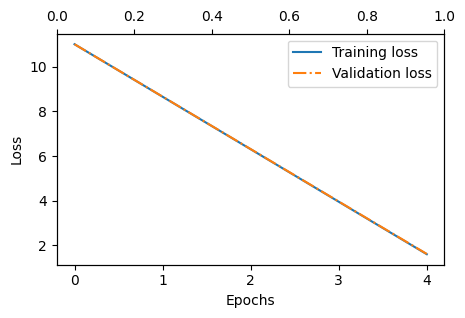

In [26]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

# Example usage:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)


In [27]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

   
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]


        if top_k is not None:
      
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

  
        if temperature > 0.0:
            logits = logits / temperature

       
            probs = torch.softmax(logits, dim=-1)  

  
            idx_next = torch.multinomial(probs, num_samples=1)  

       
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  

     
        if eos_id is not None and (idx_next == eos_id).any():
            break

      
        idx = torch.cat((idx, idx_next), dim=1)  

    return idx

In [28]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate(
            model=model, idx=encoded,
            max_new_tokens=200, context_size=context_size, temperature=0.7, top_k=40
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " ")) 
    model.train()


In [38]:
start_context = "Once upon a time there was a girl named"

generate_and_print_sample(model, tokenizer, device, start_context)

Once upon a time there was a girl named Lucy. She was very curious and loved to explore. One day, she decided to go on an adventure.  She went down a long hill and then she came to a big lake. She wanted to see what was there. She looked around and saw a big tree. It was a very old tree and she wanted to climb it.  So she climbed up the tree. She climbed to the top and looked around. She saw a big lake and she was having so much fun. Then she heard a noise coming from the lake.  She looked around and saw a bird on the ground. It was swimming around!  Lucy started to wonder what the bird was doing. She wanted to help it. She climbed up the tree and carefully climbed down.  The bird was very happy that Lucy was able to help. It made Lucy feel good inside. She said goodbye and flew off into the sky. <|endoftext|> Once upon a time, there was a big lake


In [31]:
perplexity = torch.exp(torch.mean(torch.tensor(train_losses)))
perplexity

tensor(549.4410)